<a href="https://colab.research.google.com/github/jaiswalsuraj487/EEG_TimeSeriesData_Classification_task/blob/main/22210050_CNS_Code_DL_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connecting drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [2]:
%%capture
from glob import glob
import os

!pip install mne
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# importing libraries for ML models
!pip install lazypredict
from tqdm import tqdm_notebook
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Importing libraries for CNN
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler


# Loading Data

In [3]:
all_files_path=glob('/content/drive/MyDrive/Colab Notebooks/CNS/dataverse_files/*edf')

In [4]:
healthy_file_path = [all_files_path[i] for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,15]]

In [5]:
patient_file_path = [all_files_path[i] for i in [13,14,16,17,18,19,20,21,22,23,24,25,26,27]]

## Preprocessing Data

This files are in .edf format

In [6]:
def read_data(file_path):
    datax=mne.io.read_raw_edf(file_path,preload=True) # read the datafrom path
    datax.set_eeg_reference() # by default it will do average of other channels and will consider this as reference for other channels
    datax.filter(l_freq=1,h_freq=45) # filter the data
    # till this point we had continuous data 
    # now we convert this into segments of data of specified duration 
    epochs=mne.make_fixed_length_epochs(datax,duration=25,overlap=0) # value is in seconds
    epochs=epochs.get_data() # this will return numpy array
    return epochs # number of segments , channels , length of signal

Applying this on one file

In [7]:
healthy_file_path[0]

'/content/drive/MyDrive/Colab Notebooks/CNS/dataverse_files/h02.edf'

In [8]:
data=read_data(healthy_file_path[0])

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/CNS/dataverse_files/h02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227499  =      0.000 ...   909.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Not setting metadata
36 matching events found
No baseline correction applied
0 projec

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


In [9]:
data.shape  # number of segments , channels , length of signal 

(36, 19, 6250)

## Visulizing data for first segment for all channels

for first channel

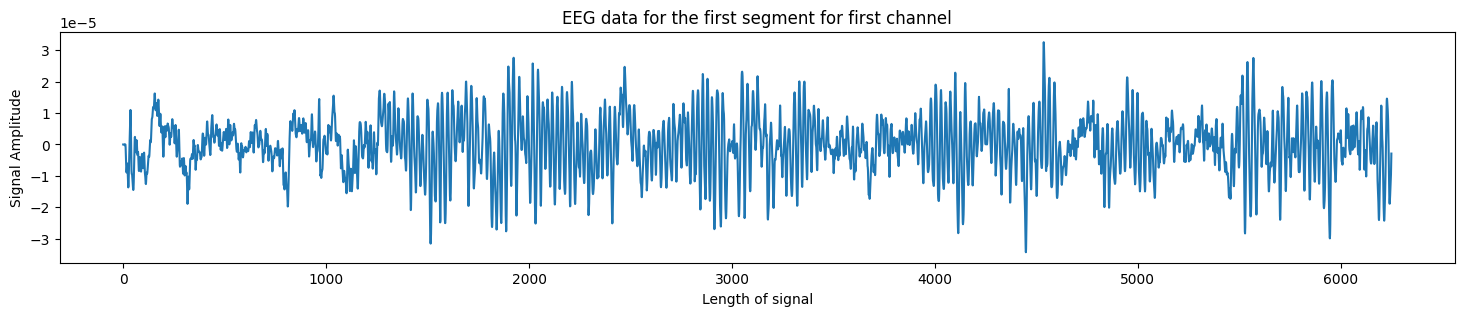

In [11]:
import matplotlib.pyplot as plt

# Assume 'data' is your numpy array of EEG data

fig = plt.figure(figsize=(18, 3))  # Set the figure size to 8x6 inches
plt.plot(data[0][0])
plt.xlabel('Length of signal')
plt.ylabel('Signal Amplitude')
plt.title('EEG data for the first segment for first channel')

plt.show()

For all 19 channels

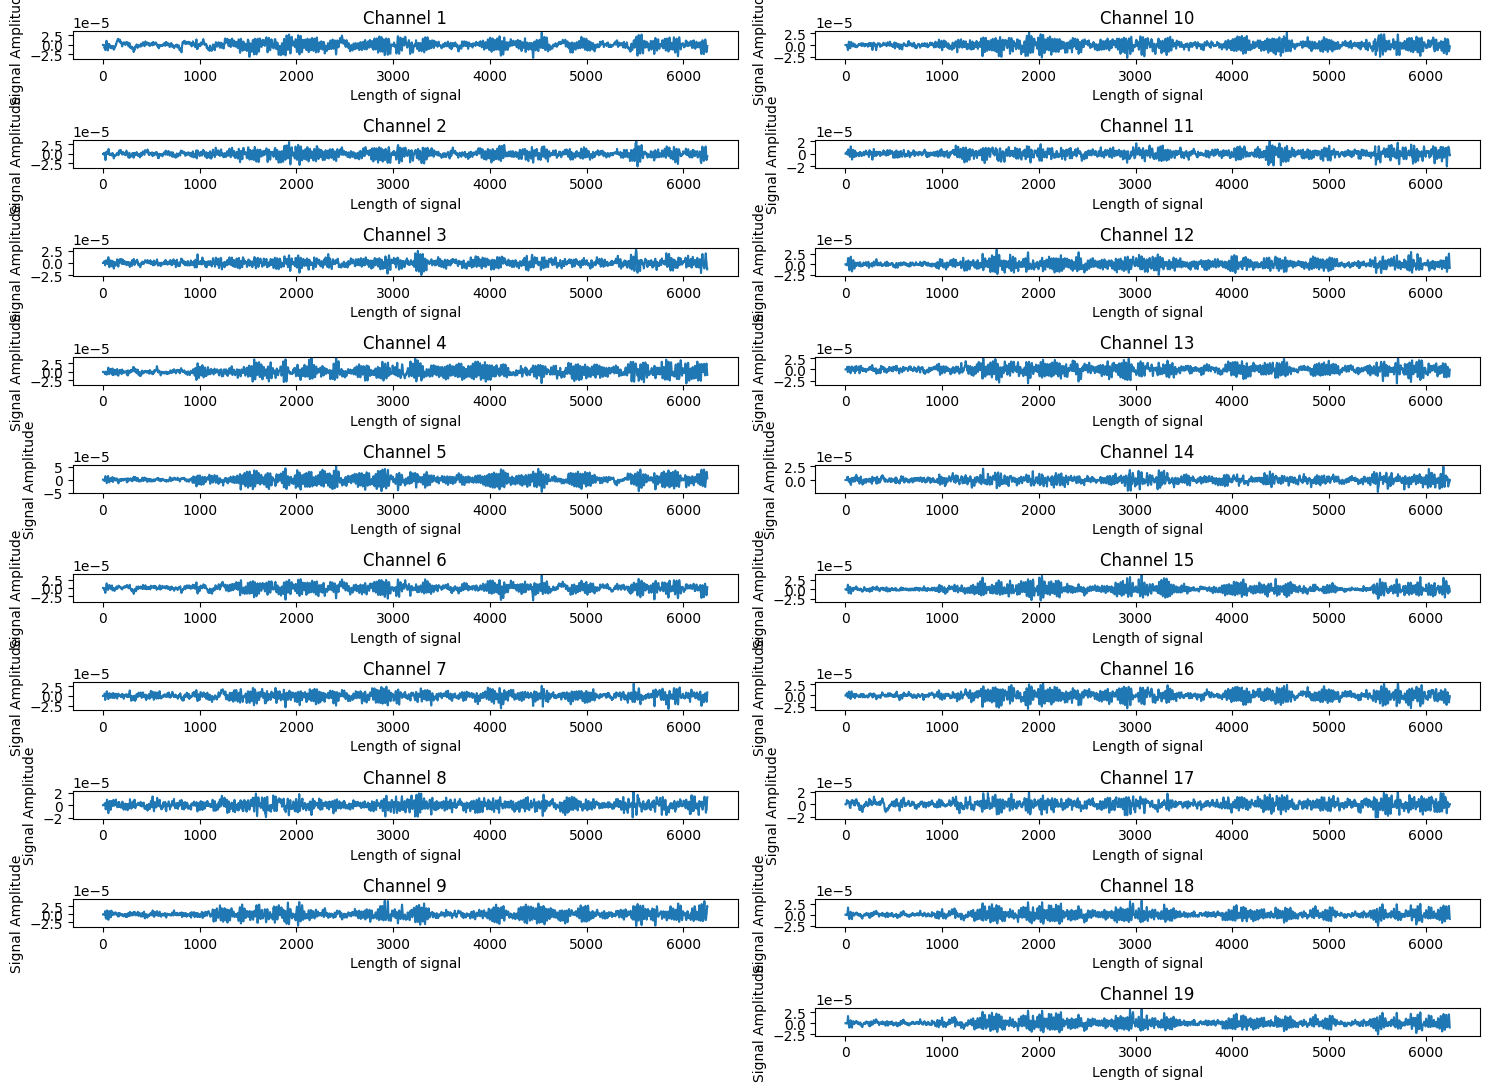

In [35]:
# create a figure with two columns
fig, axs = plt.subplots(nrows=int(data.shape[1] / 2)+1, ncols=2, figsize=(15,11))

# plot the data for each channel in the first column
for i in range(int(data.shape[1] / 2)):
    axs[i, 0].plot(data[0][i])
    axs[i, 0].set_title(f"Channel {i+1}")
    axs[i, 0].set_xlabel("Length of signal")
    axs[i, 0].set_ylabel("Signal Amplitude")

# plot the data for each channel in the second column
for i in range(9):
    axs[i, 1].plot(data[0][i+1+9])
    axs[i, 1].set_title(f"Channel {i+1+9}")
    axs[i, 1].set_xlabel("Length of signal")
    axs[i, 1].set_ylabel("Signal Amplitude")

axs[9, 0].remove()
axs[9, 1].plot(data[0][-1])
axs[9, 1].set_title(f"Channel {19}")
axs[9, 1].set_xlabel("Length of signal")
axs[9, 1].set_ylabel("Signal Amplitude")

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()


Converting all edf files into segments of fix duration(here 25 seconds)

In [10]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [11]:
# creating labels
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]

In [12]:
# combining to create X and y
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels

In [13]:
# creating group bcz we want to split based on subjects not on trails 
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

## Appling all ML models

In [14]:
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
# Below line is only for CNN
# data_array=np.moveaxis(data_array,1,2) # to move the channel as last dim bcause conv layer expect channel at end
print(data_array.shape,label_array.shape,group_array.shape)

(1142, 19, 6250) (1142,) (1142,)


Creating features

In [15]:
from scipy import stats
def mean(data):
    return np.mean(data,axis=-1)

def std(data):
    return np.std(data,axis=-1)

def ptp(data):
    return np.ptp(data,axis=-1)

def var(data):
        return np.var(data,axis=-1)

def minim(data):
      return np.min(data,axis=-1)

def maxim(data):
      return np.max(data,axis=-1)

def argminim(data):
      return np.argmin(data,axis=-1)

def argmaxim(data):
      return np.argmax(data,axis=-1)

def mean_square(data):
      return np.mean(data**2,axis=-1)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=-1))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)

def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data)),axis=-1)

In [16]:
from tqdm import tqdm_notebook
features=[]
for data in tqdm_notebook(data_array):
    features.append(concatenate_features(data))
features=np.array(features)
features.shape

  0%|          | 0/1142 [00:00<?, ?it/s]

(1142, 247)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, label_array, test_size=0.2, random_state=42, shuffle=True)


In [18]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


## summary of all ML Models

In [31]:
models # summary of all ML Models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.95,0.95,0.95,0.95,3.54
XGBClassifier,0.93,0.93,0.93,0.93,1.89
ExtraTreesClassifier,0.92,0.92,0.92,0.92,0.28
RandomForestClassifier,0.92,0.92,0.92,0.92,0.85
AdaBoostClassifier,0.92,0.92,0.92,0.92,1.74
BaggingClassifier,0.91,0.91,0.91,0.91,1.38
LinearDiscriminantAnalysis,0.90,0.90,0.90,0.90,0.15
LinearSVC,0.89,0.89,0.89,0.89,0.33
CalibratedClassifierCV,0.88,0.88,0.88,0.88,1.91


## Convolutional Neural Network

### defining model

In [17]:
def model_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
# Below line is only for CNN
data_array=np.moveaxis(data_array,1,2) # to move the channel as last dim bcause conv layer expect channel at end
print(data_array.shape,label_array.shape,group_array.shape)

(1142, 6250, 19) (1142,) (1142,)


In [19]:
scaler = StandardScaler()
data_array = scaler.fit_transform(data_array.reshape(-1, data_array.shape[-1])).reshape(data_array.shape)

Initializing CNN model

In [21]:
num_classes = len(np.unique(label_array))
input_shape = data_array.shape[1:]
model = model_cnn(input_shape=input_shape, num_classes=num_classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 6248, 32)          1856      
                                                                 
 conv1d_5 (Conv1D)           (None, 6246, 32)          3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3123, 32)         0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 3123, 32)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 3121, 64)          6208      
                                                                 
 conv1d_7 (Conv1D)           (None, 3119, 64)          12352     
                                                      

In [22]:
# perform cross-validation using GroupKFold
gkf = GroupKFold(n_splits=5)
accuracy = []
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features, train_labels = data_array[train_index], label_array[train_index]
    val_features, val_labels = data_array[val_index], label_array[val_index]
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    val_labels = to_categorical(val_labels, num_classes=num_classes)
    # fit the model
    model.fit(train_features, train_labels, epochs=100, batch_size=32, validation_data=(val_features, val_labels))    
    # evaluate the model on the validation set
    _, acc = model.evaluate(val_features, val_labels)
    accuracy.append(acc)


Epoch 1/100
29/29 [==============================] - 15s 63ms/step - loss: 0.6798 - accuracy: 0.5543 - val_loss: 0.6786 - val_accuracy: 0.5195
Epoch 2/100
29/29 [==============================] - 1s 36ms/step - loss: 0.6729 - accuracy: 0.5719 - val_loss: 0.6796 - val_accuracy: 0.6450
Epoch 3/100
29/29 [==============================] - 1s 42ms/step - loss: 0.6478 - accuracy: 0.6158 - val_loss: 0.6608 - val_accuracy: 0.6840
Epoch 4/100
29/29 [==============================] - 1s 37ms/step - loss: 0.5464 - accuracy: 0.7827 - val_loss: 0.5444 - val_accuracy: 0.8052
Epoch 5/100
29/29 [==============================] - 1s 38ms/step - loss: 0.3318 - accuracy: 0.8825 - val_loss: 0.5941 - val_accuracy: 0.7922
Epoch 6/100
29/29 [==============================] - 1s 42ms/step - loss: 0.2777 - accuracy: 0.9034 - val_loss: 0.3531 - val_accuracy: 0.8225
Epoch 7/100
29/29 [==============================] - 2s 55ms/step - loss: 0.1907 - accuracy: 0.9374 - val_loss: 0.6543 - val_accuracy: 0.7835
Epoch

In [23]:
print('Mean validation accuracy using CNN:', np.mean(accuracy)*100)

Mean validation accuracy using CNN: 91.66277766227722
